In [27]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cupy as cp
import os
%matplotlib inline

cp.cuda.Device(0).use()


<CUDA Device 0>

# Init data sizes and parametes of the PXM of ID16A

In [28]:
n = 512  # object size in each dimension
ntheta = 180  # number of angles (rotations)

pn = 64  # tomography chunk size for GPU processing
ptheta = 180  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 33.35  # [keV] xray energy
focusToDetectorDistance = 1.28
ndist = 4
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
# z1 = np.concatenate((z1,z1+1e-4,z1+5e-4))

# z1 = np.array([4.584e-3, 4.765e-3, 5e-3, 5.1e-3, 5.488e-3,5.7e-3, 6e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/magnifications2[0]  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# norm_magnifications[:] = 1
print(distances)

[0.00420013 0.00402658 0.0034558  0.00266878]


## Read real and imaginary parts of the refractive index u = delta+i beta

In [29]:
# Load a 3D object
beta0 = dxchange.read_tiff('data/beta-chip-192.tiff')#[32:-32,32:-32,32:-32]
delta0 = dxchange.read_tiff('data/delta-chip-192.tiff')#[32:-32,32:-32,32:-32]
delta0 = ndimage.zoom(delta0,n/192,order=1)
beta0 = ndimage.zoom(beta0,n/192,order=1)
print(np.mean(delta0))

# v = np.arange(-n//2,n//2)/n
# [vx,vy,vz] = np.meshgrid(v,v,v)
# v=np.exp(-200*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(beta0)))
# beta0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(delta0)))
# delta0 = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real



# pad with zeros
beta = np.zeros([2*n, 2*n, 2*n], dtype='float32')
delta = np.zeros([2*n, 2*n, 2*n], dtype='float32')
delta[n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2] = delta0
beta[n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2] = beta0

u = delta+1j*beta
u = u.astype('complex64')/2

# v = np.arange(-n//2,n//2)/n
# [vx,vy,vz] = np.meshgrid(v,v,v)
# v=np.exp(-20*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u)))
# u = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v)))
# u = u.astype('complex64')
# print(np.min(u.real))
# plt.imshow(delta0[64],cmap='gray')
# plt.colorbar()


-1.9617563e-07


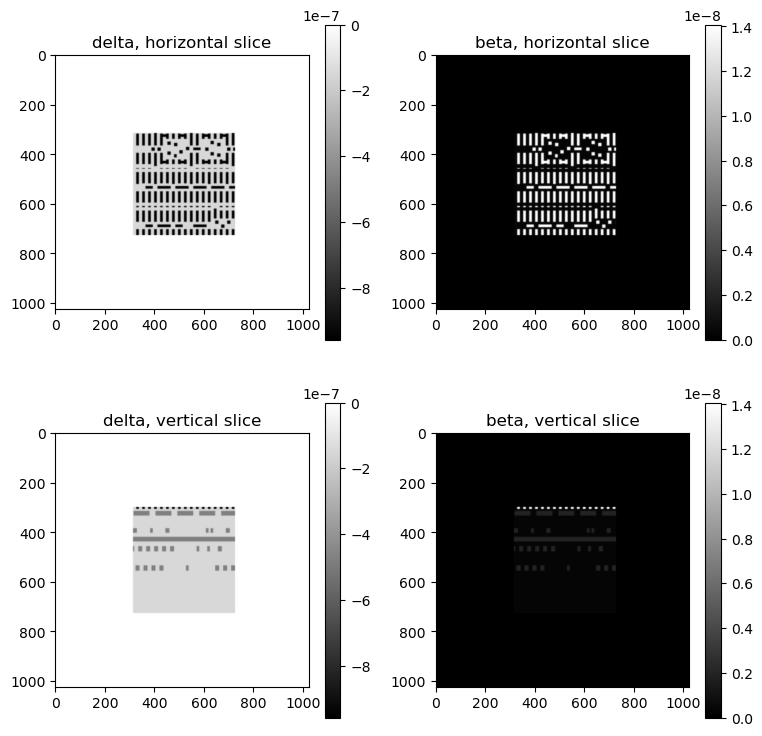

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[300].real,cmap='gray')
axs[0,0].set_title('delta, horizontal slice')
fig.colorbar(im)
im=axs[0,1].imshow(u[300].imag,cmap='gray')
axs[0,1].set_title('beta, horizontal slice')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n].real,cmap='gray')
axs[1,0].set_title('delta, vertical slice')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n].imag,cmap='gray')
axs[1,1].set_title('beta, vertical slice')
fig.colorbar(im)

Note that in this formation delta is negative

## Create a solver class for tomography, use double sizes

In [31]:
tslv = holotomo.SolverTomo(theta, ntheta, 2*n, 2*n, 2*pn, 2*center)

note pn parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pn=n. If the gpu does not have enough memory then pn should  be decreased

## Create a solver class for holography

In [32]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distances2)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

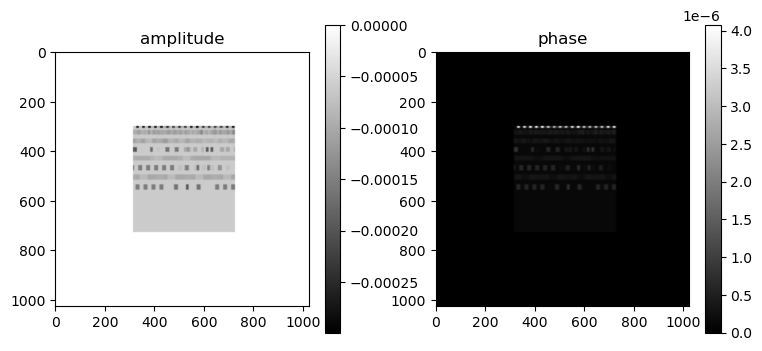

In [33]:
Ru = tslv.fwd_tomo_batch(u)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(Ru[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.imag(Ru[1]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [34]:
psi = pslv.exptomo(Ru)


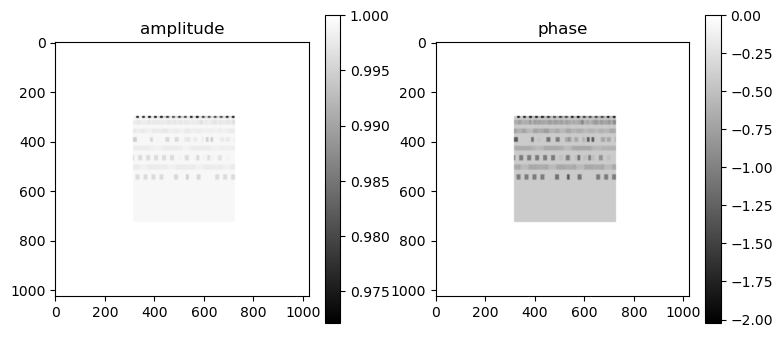

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

In [36]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0:1]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
# prb[:] = 1
# v = np.arange(-n//2,n//2)/n
# [vx,vy] = np.meshgrid(v,v)
# v=np.exp(-30*(vx**2+vy**2))
# fu = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(prb)))
# prb = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(fu*v))).astype('complex64')



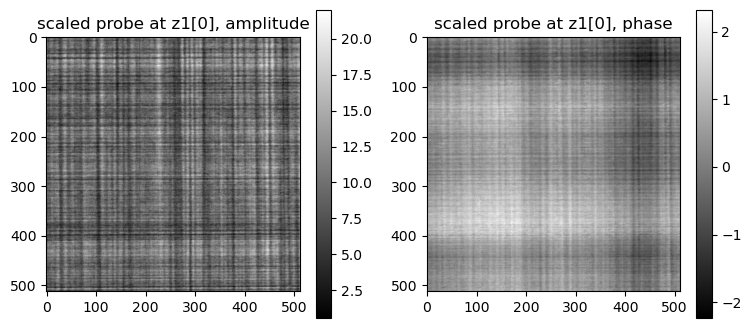

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

In [38]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]

# Compute holographic projections for all angles and all distances

In [39]:
print(psi.shape,prb.shape)
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
print(shifts_ref.shape)
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref)
fref = pslv.fwd_holo_batch(psi*0+1,prb,shifts_ref) # ignore sample
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref) # ignore probe

(180, 1024, 1024) (1, 512, 512)
(4, 180, 2)


In [40]:
# rec_abs = dxchange.read_tiff(f'/data/vnikitin/holo//psirec_chip_abs{n}_{ntheta}_{ndist}.tiff')
# rec_angle = dxchange.read_tiff(f'/data/vnikitin/holo/psirec_chip_angle{n}_{ntheta}_{ndist}.tiff')
# rec = rec_abs*np.exp(1j*rec_angle)

# rec = np.tile(np.load('/data/tmp/rec.npy'),[ntheta,1,1])
# print(rec.shape)

# fig, axs = plt.subplots(1, 2, figsize=(9, 4))
# im=axs[0].imshow(np.real(psi[0]),cmap='gray')
# fig.colorbar(im)
# axs[0].set_title('ground truth psi0, abs')
# im=axs[1].imshow(np.imag(psi[0]),cmap='gray')
# axs[1].set_title('ground truth psi0, angle')

# fig.colorbar(im)

# fig, axs = plt.subplots(1, 2, figsize=(9, 4))
# im=axs[0].imshow(np.real(rec[0]),cmap='gray')
# fig.colorbar(im)
# axs[0].set_title('reconstructed psi, abs')
# im=axs[1].imshow(np.imag(rec[0]),cmap='gray')
# axs[1].set_title('reconstructed psi, angle')

# fig.colorbar(im)

# fig, axs = plt.subplots(1, 2, figsize=(9, 4))
# im=axs[0].imshow(np.real(psi[0])-np.real(rec[0]),cmap='gray')
# axs[0].set_title('difference')

# fig.colorbar(im)
# im=axs[1].imshow(np.imag(psi[0])-np.imag(rec[0]),cmap='gray')
# fig.colorbar(im)

# frec = pslv.fwd_holo_batch(rec,prb,shifts_ref)


# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# im=axs[0].imshow(np.abs(fpsi[0,0]),cmap='gray')
# fig.colorbar(im)
# axs[0].set_title('modeled data |Gpsi0|')

# im=axs[1].imshow(np.abs(frec[0,0]),cmap='gray')
# axs[1].set_title('modeled data |Gpsi|')

# fig.colorbar(im)
# im=axs[2].imshow(np.angle(frec[0,0])-np.angle(fpsi[0,0]),cmap='gray',vmin=-0.2,vmax=0.2)
# axs[2].set_title('difference')
# print(np.mean((np.angle(frec[0,0])-np.angle(fpsi[0,0]))[300:400,300:400]))
# print(np.mean(np.angle(psi[0])))
# print(np.mean(np.angle(frec[0])))

# fig.colorbar(im)

## Take squared absolute value to simulate data on the detector, ref fields, and data with homogeneous ref fields  

In [41]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2
data0 = np.abs(fpsi0)**2

# !!!Note that simple ref-field correction creates artifacts!!! Demonstration:

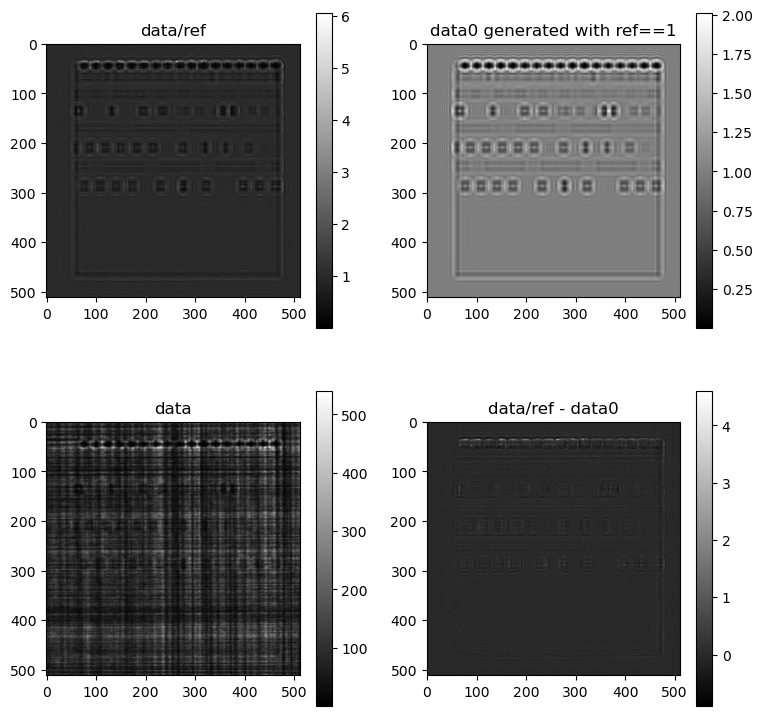

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0]/ref[0,0],cmap='gray')
axs[0,0].set_title('data/ref')
fig.colorbar(im)
im=axs[0,1].imshow(data0[0,0],cmap='gray')
axs[0,1].set_title('data0 generated with ref==1')
fig.colorbar(im)
im=axs[1,0].imshow(data[0,0],cmap='gray')
axs[1,0].set_title('data')
fig.colorbar(im)
im=axs[1,1].imshow(data[0,0]/ref[0,0]-data0[0,0],cmap='gray')
axs[1,1].set_title('data/ref - data0')
fig.colorbar(im)

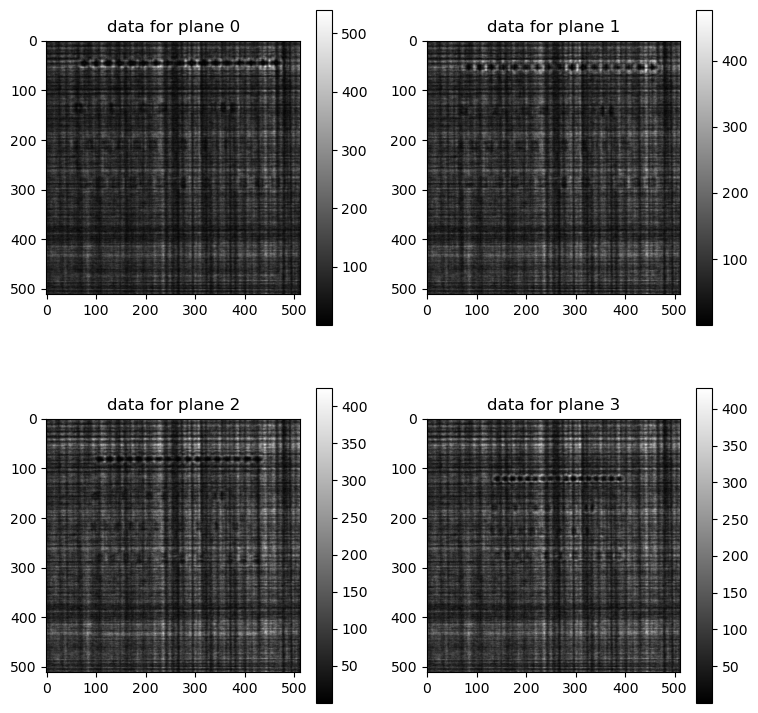

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,1],cmap='gray')
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[-1,1],cmap='gray')
axs[1,1].set_title('data for plane 3')
fig.colorbar(im)

# Save data nd ref fields

In [44]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'data/modeling/data_chip_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(ref[k,0],f'data/modeling/ref_chip_{n}_{k}',overwrite=True)
np.save('shifts',shifts)
np.save('psi',psi)

In [47]:
np.amax(shifts)

0.0